In [1]:
import pandas as pd

train_features = pd.read_csv('train_features.csv')
train_salaries = pd.read_csv('train_salaries.csv')
test_features = pd.read_csv('test_features.csv')

# Load the data: The train features and train salaries are joined on the `jobID` column.

In [2]:
train_data = train_features.merge(train_salaries,on=['jobId'])
train_data.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


# EDA

Goals:

* Convert categorical nominal features into "dummy columns"
* Identify and drop any useless features
    * Identify any features where the "dummy sum" is zero
    * Identify any features where every value is unique.
* Create a class of functions that will properly format the train set or test set.

The `jobId` column is unique to each to each target. We can see this because the count of the unique job id equals the number of rows. Therefor we drop this column as it has no predictive power.

In [3]:
i = 'jobId'
fraction = 100*len(train_data[i].unique())/len(train_data)
print('% of jobids that are unique: {}'.format(fraction))
train_data.drop(i,axis=1,inplace=True)

% of jobids that are unique: 100.0


# Go through all the categorical columns dummy them;

In [4]:
categorical = ['companyId','jobType','degree','major','industry']
train_data = train_data.copy()
for i in categorical:
    _ = pd.get_dummies(train_data[i])
    if len(_.columns)>1:
        #drop the last dummy to prevent over correlation of features
        _.drop(_.columns[-1],axis=1,inplace=True)
    #drop the original feature we made each categorical feature from
    train_data.drop(i,axis=1,inplace=True)
    train_data = pd.concat([train_data,_],axis=1)

# Identify any features with a total sum of the dummy columns to be zero. 
# If they exist, drop it.

In [5]:
drop_these = []
for c in train_data.drop('salary',axis=1).columns:
    if train_data[c].sum()==0:
        print(c)
        drop_these.append(c)
drop_these

[]

# Our Data set now has the structure

In [6]:
train_data

,yearsExperience,milesFromMetropolis,salary,COMP0,COMP1,COMP10,COMP11,COMP12,COMP13,COMP14,...,ENGINEERING,LITERATURE,MATH,NONE,AUTO,EDUCATION,FINANCE,HEALTH,OIL,SERVICE
0,10,83,130,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,3,73,101,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,10,38,137,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,8,17,142,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,8,16,163,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,19,94,88,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
999996,12,35,160,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
999997,16,81,64,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
999998,6,5,149,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


# Explore the target data, ensure that it's approximately normal. Confirm this with a histogram and Q-Q plot.

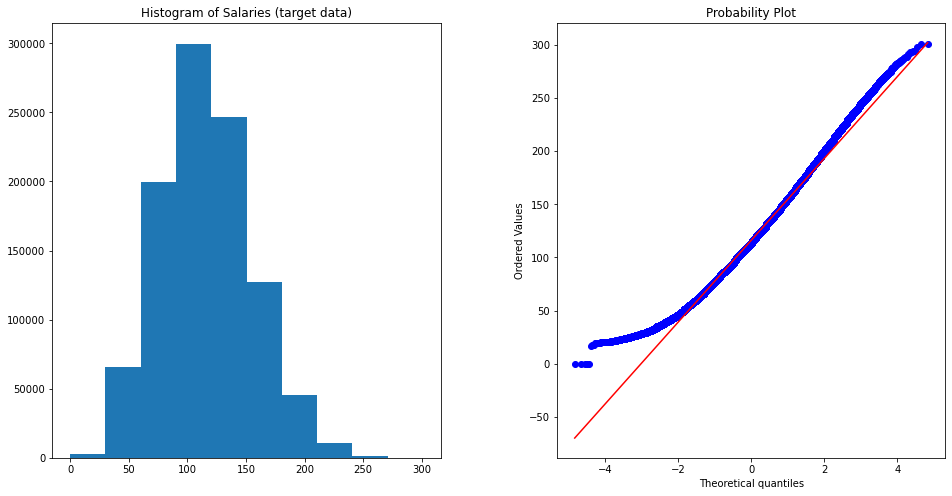

In [7]:
import matplotlib.pyplot as plt
from scipy import stats
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title("Histogram of Salaries (target data)")
plt.hist(train_data['salary'])
plt.subplot(1,2,2)
plt.title('Q-Q plot')
stats.probplot(train_data['salary'],plot=plt)
plt.subplots_adjust(wspace=0.3)
plt.show()

# The target is slightly positively skewed, but is "normal" enough to do a regression on.

# Put all our features on the same scale as each other for predictability purposes using standard scalar

In [8]:
from sklearn.preprocessing import StandardScaler

target = 'salary'
y = train_data[target]
X = train_data.drop(target,axis=1)
columns = X.columns
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X,columns=columns)
X.head()

,yearsExperience,milesFromMetropolis,COMP0,COMP1,COMP10,COMP11,COMP12,COMP13,COMP14,COMP15,...,ENGINEERING,LITERATURE,MATH,NONE,AUTO,EDUCATION,FINANCE,HEALTH,OIL,SERVICE
0,-0.276245,1.159051,-0.126156,-0.126784,-0.127146,-0.126996,-0.126634,-0.127337,-0.127142,-0.127114,...,-0.249486,-0.249685,4.037417,-1.066946,-0.408391,-0.408185,-0.408265,2.450512,-0.408105,-0.407885
1,-1.246797,0.812763,-0.126156,-0.126784,-0.127146,-0.126996,-0.126634,-0.127337,-0.127142,-0.127114,...,-0.249486,-0.249685,-0.247683,0.937254,-0.408391,-0.408185,-0.408265,-0.408078,-0.408105,-0.407885
2,-0.276245,-0.399244,-0.126156,-0.126784,-0.127146,-0.126996,-0.126634,-0.127337,-0.127142,-0.127114,...,-0.249486,-0.249685,-0.247683,-1.066946,-0.408391,-0.408185,-0.408265,2.450512,-0.408105,-0.407885
3,-0.553546,-1.126448,-0.126156,-0.126784,-0.127146,-0.126996,-0.126634,-0.127337,-0.127142,-0.127114,...,-0.249486,-0.249685,-0.247683,-1.066946,2.448631,-0.408185,-0.408265,-0.408078,-0.408105,-0.407885
4,-0.553546,-1.161077,-0.126156,-0.126784,-0.127146,-0.126996,-0.126634,-0.127337,-0.127142,-0.127114,...,-0.249486,-0.249685,-0.247683,-1.066946,-0.408391,-0.408185,2.449391,-0.408078,-0.408105,-0.407885


# Using the pearson correlation coefficient we can find the most relevant features. Features with an absolute value of high correlation with the target variable, salary, will probably be good predictors.

In [14]:
import numpy as np
correlations = {}
for col in X.columns:
    corr = np.corrcoef(X[col], y)[0][1]
    correlations[col] = [corr]
relevant_features = pd.DataFrame(correlations).transpose().sort_values(by=0,ascending=False).reset_index()
most_relevant = relevant_features[relevant_features[0].apply(lambda x: np.abs(x)>0.09)]
least_relevant = relevant_features[relevant_features[0].apply(lambda x: np.abs(x)<=0.09)]

In [11]:
list(most_relevant['index'])

['yearsExperience',
 'CEO',
 'DOCTORAL',
 'CTO',
 'CFO',
 'MASTERS',
 'OIL',
 'FINANCE',
 'ENGINEERING',
 'BUSINESS',
 'BACHELORS',
 'MATH',
 'COMPSCI',
 'SENIOR',
 'SERVICE',
 'EDUCATION',
 'JUNIOR',
 'HIGH_SCHOOL',
 'milesFromMetropolis',
 'NONE',
 'JANITOR']

In [15]:
list(least_relevant['index'])

['CHEMISTRY',
 'BIOLOGY',
 'LITERATURE',
 'COMP40',
 'COMP2',
 'COMP44',
 'COMP13',
 'COMP21',
 'COMP41',
 'COMP58',
 'COMP34',
 'COMP29',
 'COMP16',
 'COMP61',
 'COMP17',
 'COMP14',
 'COMP51',
 'COMP62',
 'COMP49',
 'COMP23',
 'COMP60',
 'COMP25',
 'COMP4',
 'COMP52',
 'COMP22',
 'COMP3',
 'COMP38',
 'COMP24',
 'COMP6',
 'COMP56',
 'COMP11',
 'COMP36',
 'COMP39',
 'COMP12',
 'COMP1',
 'COMP46',
 'COMP10',
 'COMP33',
 'COMP8',
 'COMP32',
 'COMP0',
 'COMP26',
 'COMP27',
 'COMP47',
 'COMP28',
 'COMP20',
 'COMP5',
 'COMP7',
 'COMP50',
 'COMP59',
 'COMP15',
 'COMP43',
 'COMP48',
 'COMP35',
 'COMP19',
 'COMP30',
 'COMP45',
 'COMP55',
 'COMP31',
 'COMP18',
 'COMP54',
 'COMP42',
 'COMP57',
 'COMP53',
 'COMP37',
 'HEALTH',
 'MANAGER',
 'AUTO']

# Create a class that preprocesses the dataset, regardless of it being the train or test set, and prepares it for model training/inference, using the previous steps.

In [16]:
class etl:
    def __init__(self,data):
        self.data = data
        self.target = 'salary'
        self.relevant_columns = ['yearsExperience','CEO','DOCTORAL','CTO','CFO','MASTERS',
 'OIL','FINANCE','ENGINEERING','BUSINESS','BACHELORS','MATH',
 'COMPSCI','SENIOR','SERVICE','EDUCATION','JUNIOR','HIGH_SCHOOL','milesFromMetropolis','JANITOR','salary']
        self.categorical = ['companyId','jobType','degree','major','industry']
        
    def get_dummies(self,data):
        for i in self.categorical:
            _ = pd.get_dummies(self.data[i])
            self.data = pd.concat([self.data,_],axis=1)
            self.data.drop(i,axis=1,inplace=True)
        
        drop_these = [j for j in self.data.columns if j not in self.relevant_columns]
        self.data.drop(drop_these,axis=1,inplace=True)
        return self.data
    
    def scaler(self,data):
        if self.target in data.columns:
            y = data[self.target]
            X = data.drop(self.target,axis=1)
        else:
            X = data
            y = None
        columns = X.columns
        X = StandardScaler().fit_transform(X)
        X = pd.DataFrame(X,columns=columns)
        return X,y
    
    def transform(self):
        data = self.get_dummies(self.data)
        data = self.scaler(data)
        return data

# Ensure this class works, use it to format both the train and test sets.

In [17]:
train2 = train_features.merge(train_salaries,on=['jobId'])
X_train,y_train = etl(train2).transform()
X_test,y_test = etl(test_features).transform()
X_test

,yearsExperience,milesFromMetropolis,CEO,CFO,CTO,JANITOR,JUNIOR,SENIOR,BACHELORS,DOCTORAL,HIGH_SCHOOL,MASTERS,BUSINESS,COMPSCI,ENGINEERING,MATH,EDUCATION,FINANCE,OIL,SERVICE
0,1.386060,0.812524,-0.377863,-0.378123,-0.377385,-0.378401,-0.378002,-0.378313,-0.458870,-0.460734,1.788067,-0.460943,-0.248047,-0.249008,-0.24926,-0.247719,-0.408038,-0.408655,-0.407711,-0.408755
1,1.108790,-0.087450,-0.377863,-0.378123,-0.377385,-0.378401,2.645485,-0.378313,-0.458870,-0.460734,-0.559263,-0.460943,-0.248047,-0.249008,-0.24926,-0.247719,-0.408038,-0.408655,-0.407711,-0.408755
2,0.692884,-1.402798,-0.377863,-0.378123,2.649811,-0.378401,-0.378002,-0.378313,-0.458870,-0.460734,-0.559263,2.169468,-0.248047,-0.249008,-0.24926,-0.247719,-0.408038,-0.408655,-0.407711,-0.408755
3,0.276979,1.608656,-0.377863,-0.378123,-0.377385,-0.378401,-0.378002,-0.378313,-0.458870,-0.460734,1.788067,-0.460943,-0.248047,-0.249008,-0.24926,-0.247719,-0.408038,-0.408655,2.452717,-0.408755
4,-0.277562,-0.191294,-0.377863,-0.378123,-0.377385,-0.378401,2.645485,-0.378313,-0.458870,2.170451,-0.559263,-0.460943,-0.248047,-0.249008,-0.24926,-0.247719,-0.408038,-0.408655,2.452717,-0.408755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0.276979,-1.610485,-0.377863,-0.378123,-0.377385,-0.378401,-0.378002,-0.378313,2.179268,-0.460734,-0.559263,-0.460943,-0.248047,-0.249008,-0.24926,4.036824,-0.408038,-0.408655,2.452717,-0.408755
999996,1.108790,0.604838,-0.377863,-0.378123,-0.377385,-0.378401,-0.378002,-0.378313,-0.458870,-0.460734,-0.559263,-0.460943,-0.248047,-0.249008,-0.24926,-0.247719,-0.408038,-0.408655,-0.407711,-0.408755
999997,-1.525279,1.435584,-0.377863,-0.378123,-0.377385,2.642696,-0.378002,-0.378313,-0.458870,-0.460734,-0.559263,-0.460943,-0.248047,-0.249008,-0.24926,-0.247719,-0.408038,-0.408655,2.452717,-0.408755
999998,0.276979,0.466380,-0.377863,-0.378123,2.649811,-0.378401,-0.378002,-0.378313,-0.458870,2.170451,-0.559263,-0.460943,-0.248047,-0.249008,-0.24926,4.036824,-0.408038,-0.408655,2.452717,-0.408755


# Now we're ready to attempt modelling techniques due to the vast number of possible features and non-obvious nature of each's predictability, lets try both a linear and non-linear technique to see if they predict well.

# Split the test set into a validation set to fit the model. Consider using Stochastic gradient descent regressor as a base line, and RandomForestRegressor as an attempt to deal with any non-linearities.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2)
performance = {}
for model in [SGDRegressor(),RandomForestRegressor()]:
    model.fit(X=X_train,y=y_train)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    r2_train = r2_score(y_pred_train,y_train)
    rmse_train = np.sqrt(mean_squared_error(y_pred_train,y_train))
    r2_val = r2_score(y_pred_val,y_val)
    rmse_val = np.sqrt(mean_squared_error(y_pred_val,y_val))
    performance[model] = (r2_val,r2_train,rmse_val,rmse_train)
performance

{SGDRegressor(): (0.6310591381498323,
  0.6316594747515554,
  20.103056998722778,
  20.11611945143814),
 RandomForestRegressor(): (0.5962856344480363,
  0.8533979931870099,
  22.235513367274336,
  13.531698259316409)}

# Random forest is over fitting. Thus for the test set predictions we can use SGDRegressor(). The model performance could be fine tuned given more computational power and time, but an r2 score of 0.63 indicates some predictive power.


# Now lets forecast on the text set using our train set.

In [20]:
sgd = SGDRegressor()
sgd.fit(X_train,y_train)
y_pred = sgd.predict(X_test)
y_pred

array([119.30402139,  97.8109767 , 165.10297689, ...,  44.17700964,
       161.98799922, 110.79364706])

In [21]:
pd.DataFrame(y_pred).to_csv('test_salaries.csv')